In [1]:
from fastai.structured import *
from fastai.column_data import *
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
import pickle

In [2]:
# lets load the data
df = pd.read_csv('course_ratings.csv')

In [3]:
#lets remove high rating rows
joined = df.drop(df[df['rating'] > 5].index)

In [4]:
# lets define catigorical vars
cat_vars = ['user','course','category','job','institution','state']
#coninuous vars
cont_vars = ['rating']

# df length
n = len(df)

# test percentage
testp = n*.2

#lets update features, categoricial should be category and continuous should be float32
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
    
for v in cont_vars:
    joined[v] = joined[v].fillna(0).astype('float32')

In [5]:
# we have to convert all category variables into contiguous ones and save the look up table
lookup_table = {}
for c in cat_vars:
    uq = joined[c].unique()
    col2idx =  {o:i for i,o in enumerate(sorted(uq))}
    lookup_table[c] = col2idx
    joined[c] = joined[c].apply(lambda x: col2idx[x])

In [6]:
#lets save the mapper for later use
with open('models/data/lookup_table', 'wb') as fp:
    pickle.dump(lookup_table, fp)

In [7]:
#lets check lookup table
with open ('models/data/lookup_table', 'rb') as fp:
    lut_load = pickle.load(fp)

#lut_load

In [8]:
# create a test/train set split
joined, joined_test = train_test_split(joined, test_size=0.25)
df = joined.drop('rating', axis=1)
y = joined['rating']
df_test = joined_test.drop('rating', axis=1)

# create a validation set of ids
train_ratio = 0.75
train_size = int(len(df) * train_ratio)
val_idx = list(range(train_size, len(df)))

with open('models/data/val_idx', 'wb') as fp:
    pickle.dump(val_idx, fp)
    
with open('models/data/ratings', 'wb') as fp:
    pickle.dump(y, fp)

In [9]:
#final df , everything is numeric and continguous
with open('models/data/final_df', 'wb') as fp:
    pickle.dump(df, fp)

In [10]:
df.head(10)

,user,course,category,job,institution,state
2125,33452,74,12,12,14,6
20214,26835,37,8,3,14,30
98012,728,184,4,28,8,39
99405,3772,16,0,42,0,28
116408,11116,151,9,6,11,24
132332,4448,175,7,6,11,35
79537,1634,174,7,6,0,41
61287,50044,3,1,28,0,23
35336,39696,28,7,6,11,6
58860,9427,171,7,6,9,23


In [11]:
#lets build the initial model
md = ColumnarModelData.from_data_frame("models/", val_idx, df, y.astype(np.float32), cat_flds=cat_vars, bs=128, test_df=df_test)

In [12]:
#build embedding matrix, matrices should be 1 bigger then the the number of categorical options to leave room for unknown
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
with open('models/data/emb_sizes', 'wb') as fp:
    pickle.dump(emb_szs, fp)

In [13]:
#build the learner, 
# .04 dropout on the embedding matrix
# 1000 and 500 nodes on 2 different layers
# .001 and .01 dropouts
# specifying the range of y (rating) to be 0-5
m = md.get_learner(emb_szs,0 ,0.4, 1, [200,100], [0.5,0.01],y_range=(0,5))

In [14]:
m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 2605900)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 11000)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 8]),
                           ('trainable', True),
                           ('nb_params', 120)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 23]),
                           ('trainable', True),
                           ('nb_params', 1058)])),
             ('Embedding-5',
              OrderedDict([('input_sh

In [15]:
#lets find a learning rate
m.lr_find()

epoch      trn_loss   val_loss                                
    0      1.260395   1.260362  



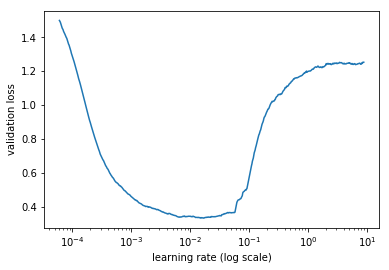

In [16]:
m.sched.plot(100)

In [17]:
lr = 1e-3

In [18]:
# Local
#m.fit(lr, 2, cycle_len=2)

In [19]:
# GPU
# lets fit the model, 50 epochs with restarts
m.fit(lr, 10, cycle_len=1, wds=1e-3)

epoch      trn_loss   val_loss                                
    0      0.27591    0.258001  
    1      0.225794   0.221993                                
    2      0.207916   0.219886                                
    3      0.20167    0.219657                                
    4      0.191297   0.219105                                
    5      0.191152   0.218954                                
    6      0.182185   0.217622                                
    7      0.182202   0.217662                                
    8      0.177202   0.217691                                
    9      0.180274   0.218259                                



[array([0.21826])]

In [20]:
m.save('mdl')

In [21]:
m.load('mdl')

In [22]:
x,y=m.predict_with_targs()

In [23]:
pred_test=m.predict(is_test=True)

In [24]:
joined_test['rating_pred'] = pred_test

In [25]:
joined_test[['rating','rating_pred']].head(10)

,rating,rating_pred
53617,2.92,3.597658
152111,3.50,3.920702
165797,4.68,4.011629
39834,3.85,4.216658
36076,3.73,4.130341
69972,4.62,4.416694
107879,4.08,4.163901
44763,3.92,4.421182
62763,3.81,3.720475
91411,3.62,3.717208


In [26]:
rms = sqrt(mean_squared_error(joined_test['rating'], joined_test['rating_pred']))

In [27]:
# we achieved a root mean squared error of .47
rms

0.4652717927607902

In [28]:
test_record = df_test.iloc[0]

In [29]:
joined_test.iloc[0]

user             23768
course               4
category             7
rating            2.92
job                 29
institution          9
state               30
rating_pred    3.59766
Name: 53617, dtype: object

In [30]:
cat = test_record[cat_vars].values.astype(np.int64)[None]
contin = test_record.drop(cat_vars).values.astype(np.float32)[None]

#Prediction
model = m.model
model.eval()
prediction = to_np(model(V(cat),[]))

In [31]:
prediction[0][0]

3.597658

In [32]:
#model is ready, need to create simple api and also test with new data since the original was pulled

In [33]:
# lets load up the test set

In [34]:
post_test = pd.read_csv('test_ratings.csv')

In [35]:
for v in cat_vars: 
    post_test[v] = post_test[v].astype('category').cat.as_ordered()
    
for v in cont_vars:
    post_test[v] = post_test[v].fillna(0).astype('float32')

In [36]:
for c in cat_vars:
    uq = post_test[c].unique()
    col2idx =  {o:i for i,o in enumerate(sorted(uq))}
    post_test[c] = post_test[c].apply(lambda x: col2idx[x])

In [37]:
post_test

,user,course,category,rating,job,institution,state
0,351,44,5,4.05,14,0,1
1,296,24,5,3.23,2,0,1
2,217,24,5,3.77,2,0,1
3,118,28,4,4.59,2,4,22
4,8,39,6,3.73,2,7,25
5,186,113,6,2.82,2,4,1
6,186,110,4,3.73,2,4,1
7,186,25,4,3.73,2,4,1
8,336,127,4,4.77,2,1,1
9,150,108,4,3.73,2,7,1


In [38]:
# make a function to apply to test df

In [39]:
def get_rating(df):
    cat = df[cat_vars].values.astype(np.int64)[None]
    prediction = to_np(model(V(cat),[]))
    return prediction[0][0]

In [40]:
post_test['prating'] = post_test.apply(get_rating, axis=1)

In [41]:
post_test.head(10)

,user,course,category,rating,job,institution,state,prating
0,351,44,5,4.05,14,0,1,4.379772
1,296,24,5,3.23,2,0,1,3.499788
2,217,24,5,3.77,2,0,1,3.960741
3,118,28,4,4.59,2,4,22,4.482213
4,8,39,6,3.73,2,7,25,3.924491
5,186,113,6,2.82,2,4,1,3.875221
6,186,110,4,3.73,2,4,1,3.854032
7,186,25,4,3.73,2,4,1,4.004535
8,336,127,4,4.77,2,1,1,4.292073
9,150,108,4,3.73,2,7,1,3.934483


In [42]:
rms_pt = sqrt(mean_squared_error(post_test['rating'], post_test['prating']))

In [43]:
rms_pt

0.6436549417636569